# Demo: Calibration Directly using Simulator (no emulator in MCMC)

- Author: Arthur Lui
- Email: alui@lanl.gov
- Date: 18 Feb, 2022

## Introduction
This notebook demonstrates how model calibration can be done in SEPIA directly using a computer model, i.e. without an emulator.
Discrepancy can be incorporated, and (function, observational, and discrepancy) predictions can be made at new locations (`x`), given the inferred
(SEPIA) model and physical parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Control number of threads for linear algebra operations.
# Probably need only one of these.

import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
os.environ['OPENBLAS_MAIN_FREE'] = '8'

In [3]:
# Other library imports.

import sepia
from sepia import SepiaData, SepiaModel
from sepia.contrib.emufree_calib_model import DBasis, radial_basis
from sepia.contrib.emufree_calib_model import sqexpkernel
from scipy.linalg import block_diag
from sepia.contrib.ppl import distributions as dist
from sepia.contrib.ppl.distributions import GP
import numpy as np
from sepia.contrib.ppl.util.pbar import pbrange
from scipy.spatial import distance

from sepia.contrib.emufree_calib_model import posterior_predictive

import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams["animation.html"] = "html5"  # or jshtml, which results in larger but more interactive graphs.
orig_dpi = 72  # original dpi.

We first construct a toy dataset. We assume a computer model which returns a function. Specifically., a computer model (simulator) $\eta(x, t)$ will take accepts inputs $x$ and $t$ (both possibly vectors) and
returns a vector of outputs (of length $n$). For simplicity in this example, the ($n$) indexing points at which the simulator $\eta$ is evaluated is assumed to be a fixed grid, although it need not be.
The simulator indexing points here is a length-60 regular grid from 0 to 1.

Let the simulator indexing points be $\mathbf s = \{s_1, \dots, s_{60}\}$.
The form of $\eta$ is 
$$\eta_i(x, t) = t + 0.25 \cdot \sin(s_i \cdot 4 \pi) \cdot x$$
such that $\eta(x, t) = [\eta_1(x, t), \dots, \eta_{60}(x, t)]^T$.

The discrepancy captures the differences between observations and simulator at observed inputs $x$ (but not physical parameters $t$).
It's form will be:
$$
\delta_i(x) = \begin{cases}
  (s_i - x ^ {0.2}) \cdot \sqrt{3x + 0.03}, &\text{ if } s_i > x ^ {0.2} \\
  0, &\text{ otherwise.}
\end{cases}
$$

In [4]:
# Simulator gridsize.
sim_gridsize = 60

# Simulator grid.
sim_grid = np.linspace(0, 1, sim_gridsize)

# Simulator.
def eta(x, t):
    return t[0] + 0.25 * np.sin(sim_grid * 4 * np.pi) * x[0]

# Discrepancy.
def delta(x, a=3):
    return np.clip(sim_grid - np.power(x[0], 0.2), 0, np.inf) * np.sqrt((x[0] + 0.01) * a)

With the simulator $\eta$ and discrepancy $\delta$ specified, we generate three observations, where each input $x_i$ is a scalar, the physical parameter $t$ is a scalar, 
and each response $y_i$ is a vector (of length 60, lilke the simulator).

The true discrepancy at each of the values of $x$ (0.2, 0.45, 0.7) are shown in the figure below.

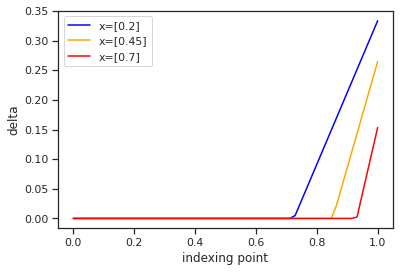

In [5]:
# Generate data.
np.random.seed(0)

num_obs = 3
X = np.linspace(.2, .7, num_obs)[:, None]
theta = np.array([.7])
lam_true = 0.01
a = 7

colors = ["blue", "orange", "red"]
true_discrepancy = [delta(x, a=a) for x in X]
ys = [np.random.normal(eta(x, theta) + delta(x, a=a), lam_true) for x in X]
y = np.concatenate(ys)

for i, x in enumerate(X):
    plt.plot(sim_grid, true_discrepancy[i], label=f"x={x}", color=colors[i])
plt.legend()
plt.xlabel("indexing point")
plt.ylabel("delta")
plt.savefig('img/delta.pdf')
plt.show()

This figure shows the generated response curves (three $y_i$'s) for different input $x_i$'s, given a true underlying $t$ of 0.7.

We will attempt to learn the discrepancy, and $\theta$ using this dataset ($s$, $x$, $y$).

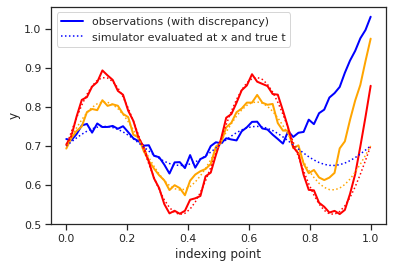

In [6]:
for i, x in enumerate(X):
    # plt.plot(sim_grid, ys[i], lw=3)
    label = None if i > 0 else "observations (with discrepancy)"
    plt.plot(sim_grid, ys[i], label=label, lw=2, color=colors[i])
for i, x in enumerate(X):
    label = None if i > 0 else "simulator evaluated at x and true t"
    plt.plot(sim_grid, eta(x, theta), label=label, ls=":", color=colors[i])
plt.xlabel("indexing point")
plt.ylabel("y")
plt.legend()
plt.savefig('img/data.pdf')
plt.show()

## SEPIA Model for calibration of physical parameters using simulator, with discrepancy

The SEPIA model being fit is

TODO:
- [ ] Put model here
- [ ] explain the how the discrepancy is modeled

In [7]:
# Base sepia data.
# TODO: sim_grid should be in SepiaData, I think y_obs_ind?
sepia_data = SepiaData(x_obs=X, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

def hinge(x, c):
    return np.maximum(x - c.T, 0)

# Create D basis.
# TODO: Allow user to specify some basic bases (e.g. Gaussian kernels, linear, constant, hinge).
num_basis = 21
knots = np.linspace(0, 1, num_basis)[:, None]

# Gaussian kernel basis.
# NOTE: kernel sd can influence results.
Dbasis = DBasis([sim_grid[:, None] for _ in X], knots, sd=1/(num_basis-1))

# Hinge basis.
# D = create_D_basis([sim_grid[:, None] for _ in X], knots, basis=hinge)

sepia_data.create_D_basis(Dbasis=Dbasis)

In [8]:
sepia_model = SepiaModel(sepia_data)

In [9]:
result = sepia_model.do_mcmc(1000, burn=3000, thinning=3)

[2022-03-15 15:44:50 | ############### | 6000/6000 (100%) | 0:00:35<0:00:00 | 168.74it/s]


In [10]:
print("result.keys(): ", result.keys())
samples = result['samples']

print("samples.keys(): ", samples.keys())

result.keys():  dict_keys(['mcmc', 'samples', 'init_state', 'kernel', 'window', 'burn', 'num_samples', 'thinning'])
samples.keys():  dict_keys(['length_scale', 'process_sd', 't', 'lam'])


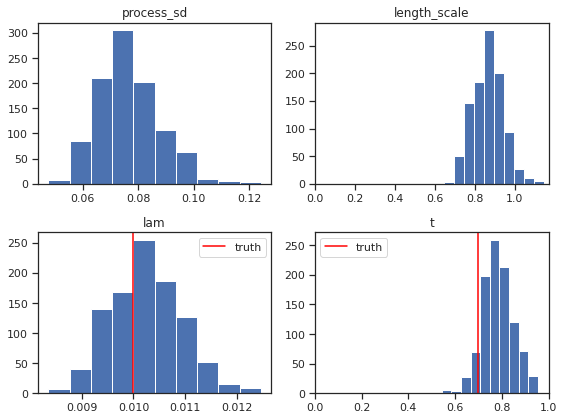

In [11]:
def plot_parameter_posterior(samples):
    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)
    plt.hist(samples["process_sd"])
    plt.title("process_sd")

    plt.subplot(2, 2, 2)
    plt.hist(samples['length_scale'])
    plt.title("length_scale")
    plt.xlim(0)

    plt.subplot(2, 2, 3)
    plt.hist(samples['lam'])
    plt.title("lam")
    plt.axvline(lam_true, color="red", label="truth")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.hist(samples["t"].flatten())
    plt.title("t")
    plt.xlim(0, 1)
    plt.axvline(theta, color="red", label="truth")
    plt.legend()
    
plot_parameter_posterior(samples)
plt.tight_layout()
plt.savefig("img/radial-basis-posteriors.pdf")
plt.show()

***

## TODO

18 Feb, 2022.
- [ ] Allow user to specify `sim_grid` in `SepiaData`
- [ ] Allow user to specify a bases form for `D` (e.g. hinges, constant, linear, Gaussian kernel)
- [X] posterior predictive method, optionally at new locations (`X`).
- [X] posterior distribution of discrepancy (`delta`), optionally at new locations (`X`).

In [12]:
# New grid at which to predict.
Xnew = np.sort(np.concatenate([X.flatten(), np.linspace(0, 1, 30)]))[:, None]

# Posterior predictives.
post_pred = posterior_predictive(
    Xnew, data=sepia_model.emu_free_model_data, post_samples=samples,
    indexing_points=[sim_grid[:, None] for _ in Xnew] # indexing points (for y) at new locations.
)

[2022-03-15 15:46:04 | ############### | 1000/1000 (100%) | 0:01:13<0:00:00 | 13.63it/s]


In [13]:
print(post_pred.keys())
post_delta = post_pred["delta"]  # discrepancy at new locations.
post_y = post_pred["predictive"]  # posterior predictive (at new locations).
post_y.shape, post_delta.shape

dict_keys(['mean_fn', 'delta', 'predictive'])


((1000, 1980), (1000, 1980))

In [14]:
# TODO: Move to src?

# For subsetting.
class Subset:
    def __init__(self, size):
        self.size = size
    def get(self, y, i):
        start = self.size * i
        end = start + self.size
        return y[start:end]

# Posterior Predictive Mean Function at (old and) new locations.

def make_plotter(fig, post_y):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        p = subset.get
        mean = subset.get(post_y.mean(0), i)
        
        if x in X.tolist():
            j = np.argwhere(X == x).flatten()[0]
            plt.scatter(sim_grid, subset.get(y, j), s=10, color="orange", label="data")
            
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, eta(x, theta) + delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_y, 0.025, 0), i)
        upper = subset.get(np.quantile(post_y, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(0.3, 1.1)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.legend(loc="lower left")
        
    return plotter

def make_delta_plotter(fig, post_delta):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        mean = subset.get(post_delta.mean(0), i)
        
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_delta, 0.025, 0), i)
        upper = subset.get(np.quantile(post_delta, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(-0.3, 0.3)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.ylabel("discrepancy")
        plt.legend(loc="lower left")
        
    return plotter

# Posterior predictive distribution (y at new locations)

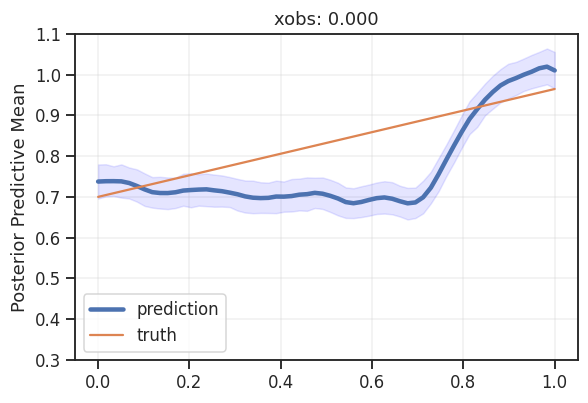

In [15]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_plotter(fig, post_y)

def animate(t):
    plt.cla();
    plotter(t, Xnew[t]);
    plt.grid(lw=0.3);
    plt.ylabel("Posterior Predictive Mean")
    
def make_reversing_frames(n):
    frames = np.arange(n)
    return np.concatenate([frames, frames[::-1]])

frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [16]:
# Save output.
save_locations = Xnew[[2, 6, 10, 15, 19, 23, 27]].flatten()
print(save_locations)

for i, x in enumerate(Xnew):
    if x in save_locations:
        animate(i)
        plt.savefig(f'img/post-pred-radial-{x[0]:.3f}.pdf')
        plt.close()

[0.06896552 0.2        0.31034483 0.45       0.5862069  0.7
 0.82758621]


# Posterior predictive distribution of the discrepancy (at new locations)

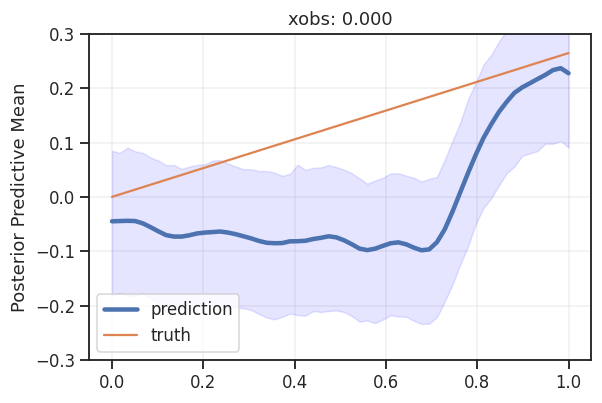

In [17]:
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_delta_plotter(fig, post_delta)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [18]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        animate(i)
        plt.savefig(f'img/post-pred-delta-radial-{x[0]:.3f}.pdf')
        plt.close()

# Redo Analysis with Hinge Basis

In [19]:
# Sepia data object.
sepia_data_hinge = SepiaData(x_obs=X, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

# Hinge basis.
Dbasis_hinge = DBasis([sim_grid[:, None] for _ in X], knots, basis=hinge, normalize=False, bias=False)

# Register the hinge basis for Sepia data object.
sepia_data_hinge.create_D_basis(Dbasis=Dbasis_hinge)

# Sepia Model.
sepia_model_hinge = SepiaModel(sepia_data_hinge)

# Fit model with MCMC.
result_hinge = sepia_model_hinge.do_mcmc(1000, burn=3000, thinning=3)
samples_hinge = result_hinge['samples']

[2022-03-15 15:47:03 | ############### | 6000/6000 (100%) | 0:00:40<0:00:00 | 149.86it/s]


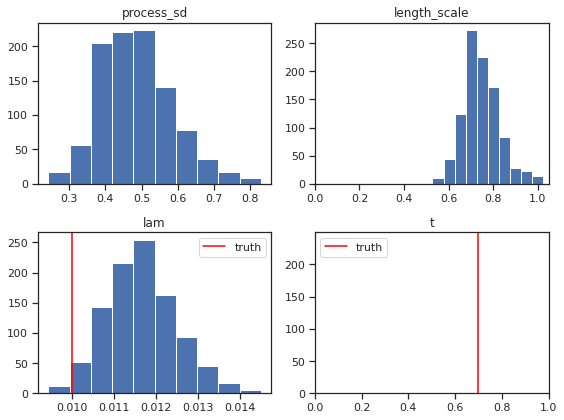

In [20]:
# Plot posterior samples.
plot_parameter_posterior(samples_hinge)
plt.tight_layout()
plt.savefig("img/hinge-basis-posteriors.pdf")
plt.show()

In [ ]:
# Posterior predictives.
post_pred_hinge = posterior_predictive(
    Xnew, data=sepia_model_hinge.emu_free_model_data, post_samples=samples_hinge,
    indexing_points=[sim_grid[:, None] for _ in Xnew] # indexing points (for y) at new locations.
)

# Posterior predictive for the discrepancy function.
post_delta_hinge = post_pred_hinge["delta"]  # discrepancy at new locations.

# Full posterior predictive for observations.
post_y_hinge = post_pred_hinge["predictive"]  # posterior predictive (at new locations).

In [ ]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_plotter(fig, post_y_hinge)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [ ]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        animate(i)
        plt.savefig(f'img/post-pred-hinge-{x[0]:.3f}.pdf')
        plt.close()

In [ ]:
# Posterior predictive of discrepancy.

plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_delta_plotter(fig, post_delta_hinge)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [ ]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        animate(i)
        plt.savefig(f'img/post-pred-delta-hinge-{x[0]:.3f}.pdf')
        plt.close()

***

# NOTE
- scaling of D
    - the ratio between the columns needs to be preserved (think about the gaussian kernel basis)
    - the ratio between the rows also needs some preservation (otherwise the covariates are all the same) 
    - consider `D = D / np.abs(D).max()`

In [ ]:
plt.imshow(Dbasis.D[:len(Dbasis.S[0]), :Dbasis.num_basis], aspect="auto")
plt.colorbar()
plt.show()

In [ ]:
Dbasis_hinge = DBasis([sim_grid[:, None] for _ in X], knots, basis=hinge, bias=False)
plt.imshow(Dbasis_hinge.D[:len(Dbasis_hinge.S[0]), :Dbasis.num_basis], aspect="auto")
plt.colorbar()
plt.show()

In [ ]:
Dbasis_hinge.D

In [ ]:
Dbasis.D